In [1]:
# Imports
import os, sys
import numpy as np
import ROOT as rt
import uproot
import h5py
import matplotlib.pyplot as plt
import root_numpy as rtnp
import pandas
from math import log10, floor
import math
from subprocess import Popen
import shlex 
import cmsstyle


Welcome to JupyROOT 6.12/07


In [2]:
# Print fit results!
# Define some fixed parameterds

useDijet = True

# Dijet variable-binwidth binning (depends on dijet resolution)
if useDijet:
    bin_edges = np.array([#1200, 1255, 1320, 1387, 1457, 1529,
                          1457, 1529,
                          1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 
                          2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 
                          4411, 4583, 4760, 4943, 5132, 5327]).astype('float') #Let's keep a reduced range for now..
                          #5574, 5737, 5951, 6173, 6402, 6638, 6882]).astype('float')
else:
    bin_edges = np.array(np.arange(1200.,5500., 100.).tolist()).astype('float') #100 GeV binning. Stop at 5600! Fit fails if going to 6800


n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]
bws = (max_bin-min_bin)/n_bins

xsecs = [0]
tag = "sig_CASE_Wkk"  
columns = {0.01: 19, 0.1: 18, 0.3: 22,0.5: 21, 0.7: 20}

In [3]:
# Open combine files and extract observed and expeced gof
for xs in xsecs:
    
    print("\nxsec={}:".format(xs) )
    for key in sorted(columns.keys()):
        print("q = {}".format(key) )
        quantile = int(key*100)

        prefix = "q{}_xs{}_{}".format(quantile,xs,tag)

        # open file
        obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
        obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]


        exp_gof_file = uproot.open('higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root'.format(PREFIX=prefix))
        exp_gof = exp_gof_file['limit'].arrays('limit')['limit']
        
        # get p-value from toys
        n_extreme = len(exp_gof[exp_gof > obs_gof])
        n_total = len(exp_gof)
        pval_toys = 1.*n_extreme/n_total
        # get p-value assuming chi2 dist (may not be valid)
        pval = rt.TMath.Prob(obs_gof,n_bins)
        
        print("Obs  = {:.1f}".format(obs_gof))
        print("Exp  = {:.1f}".format(np.mean(exp_gof)))
        print("pval (toys) = {:.2f}".format(pval_toys))
        print("pval (chi2) = {:.2f}".format(pval))


xsec=0:
q = 0.01
Obs  = 44.7
Exp  = 30.6
pval (toys) = 0.04
pval (chi2) = 0.05
q = 0.1
Obs  = 116.8
Exp  = 30.2
pval (toys) = 0.00
pval (chi2) = 0.00
q = 0.3
Obs  = 97.4
Exp  = 29.7
pval (toys) = 0.00
pval (chi2) = 0.00
q = 0.5
Obs  = 86.9
Exp  = 30.1
pval (toys) = 0.00
pval (chi2) = 0.00
q = 0.7
Obs  = 79.5
Exp  = 30.5
pval (toys) = 0.00
pval (chi2) = 0.00


For q = 0.1


Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio


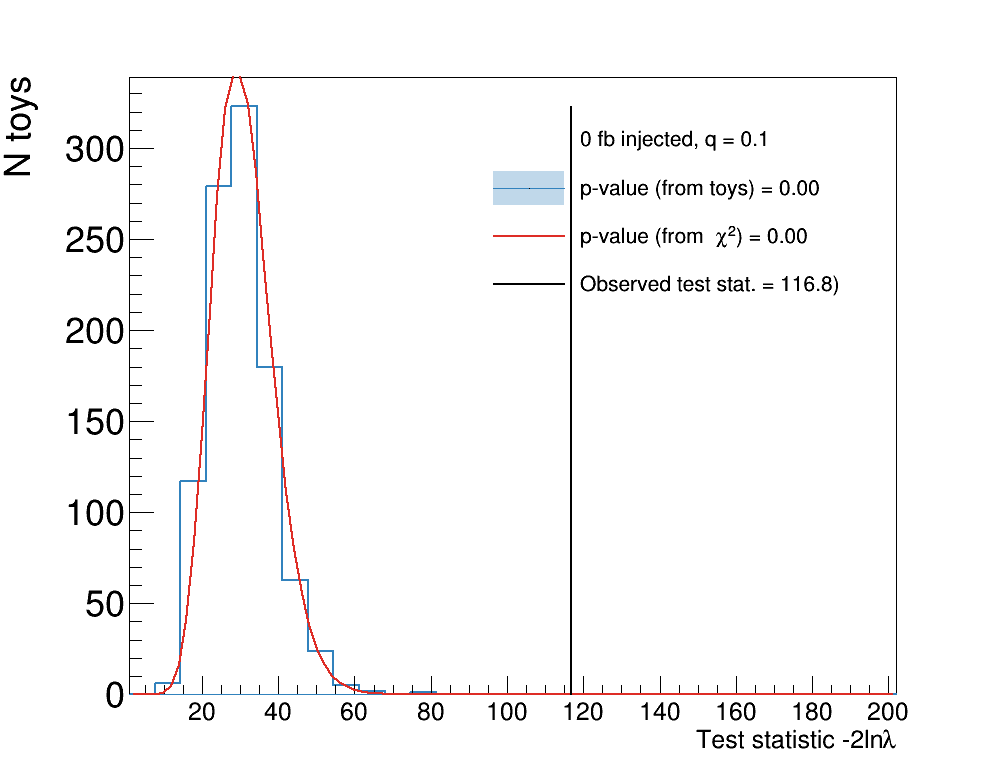

In [6]:
# Plot the test statistic for a given xsec/quantile

scol =['#fc9272','#de2d26','#fee0d2']*2
bcol =['#3182bd','#9ecae1','#deebf7']*2

xs = xsecs[0]
doChecks = True
key = 0.1

if doChecks:
#     print("\nFor xsec={}:".format(xs) )
#     for key in sorted(columns.keys()):
        print("For q = {}".format(key) )
        quantile = int(key*100)
        prefix = "q{}_xs{}_{}".format(quantile,xs,tag)
    
        obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
        obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

        exp_gof_file = uproot.open('higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root'.format(PREFIX=prefix)) #limit contains the value of the test-statistic in each toy
        exp_gof = exp_gof_file['limit'].arrays('limit')['limit']

        # get p-value from toys
        n_extreme = len(exp_gof[exp_gof > obs_gof])
        n_total = len(exp_gof)
        pval_toys = 1.*n_extreme/n_total
        # get p-value assuming chi2 dist (may not be valid)
        pval = rt.TMath.Prob(obs_gof,n_bins)
        # print('sig inj = %.1f fb, gof = %.2f, p-value (from chi2) = %.6f, p-value (from toys) = %.6f'%(sig_inj*sig_xsec,obs_gof,pval,pval_toys))

        bin_width = (max(exp_gof+[obs_gof])+np.std(exp_gof)-(min(exp_gof)-np.std(exp_gof)))/30.
        exp_gof_hist = rt.TH1D('gof','gof',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
        exp_gof_hist_gt = rt.TH1D('gof_gt','gof_gt',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
        for g in exp_gof:
            exp_gof_hist.Fill(g)
            if g > obs_gof:
                exp_gof_hist_gt.Fill(g)


        d = rt.TCanvas("ratio", "", 1000, 800)
        d.SetLeftMargin(0.13)
        # signal_hist_template    .Draw('same HIST')

        rt.gStyle.SetOptTitle(0)
        rt.gStyle.SetOptStat(0)
        f = rt.TF1("chi2","%f*ROOT::Math::chisquared_pdf(x,%i,0)"%(exp_gof_hist.Integral()*bin_width,n_bins),min(exp_gof)-np.std(exp_gof),max(exp_gof+[obs_gof])+np.std(exp_gof))

        tleg = rt.TLegend(0.48, 0.6, 0.89, 0.85)
        tleg.SetTextSize(0.05)
        tleg.SetBorderSize(0)
        tleg.SetFillStyle(0)
        tleg.SetTextSize (0.03)
        tleg.SetTextFont( 62 )
        tleg.SetTextSize (0.03)
        tleg.SetTextFont( 42 )
        exp_gof_hist.Draw('hist')
        exp_gof_hist.SetXTitle('Test statistic -2ln#lambda')
        exp_gof_hist.SetYTitle('N toys')
        exp_gof_hist.SetTitle("")
        exp_gof_hist.GetYaxis().SetLabelSize(0.05)
        exp_gof_hist.GetYaxis().SetTitleSize(0.05)
        f.SetLineColor((rt.TColor.GetColor(scol[1])))
        exp_gof_hist.SetLineWidth(2)
        exp_gof_hist.SetLineColor((rt.TColor.GetColor(bcol[0])))
        exp_gof_hist_gt.SetLineColor((rt.TColor.GetColor(bcol[0])))
        exp_gof_hist_gt.SetFillColorAlpha((rt.TColor.GetColor(bcol[0])), 0.30)
        exp_gof_hist_gt.Draw('fhistsame')
        f.Draw('same')
        line = rt.TLine(obs_gof,0,obs_gof,exp_gof_hist.GetMaximum())
        line.SetLineWidth(2)
        line.Draw()
        tleg.AddEntry(None,"{} fb injected, q = {}".format(xs,key),"")
        tleg.AddEntry(exp_gof_hist_gt,'p-value (from toys) = %.2f'%pval_toys)
        tleg.AddEntry(f,'p-value (from #chi^{2}) = %.2f'%pval,'l')
        tleg.AddEntry(line,'Observed test stat. = {:.1f})'.format(obs_gof),'l')
        tleg.Draw()
        latex = rt.TLatex()
        latex.SetNDC ()
        latex.SetTextSize (0.03)
        latex.SetTextFont( 62 )
        # latex.DrawLatex (0.67 ,0.27 , "%.1f fb^{-1} dijet events"%lumi)
        latex.SetTextSize (0.03)
        latex.SetTextFont( 42 )
        # latex.DrawLatex(0.67 ,0.23 , 'q = {} - {}'.format(lower_bound,qkey))
        d.Draw()
#         d.SaveAs("{}_gof.pdf".format(prefix))

For q = 0.1
rej
 Category rej: mjj bin = 5037.5 gof = 5.84799211954
acc
 Category acc: mjj bin = 1493.0 gof = 10.9630567689
 Category acc: mjj bin = 2158.5 gof = 6.00498086521
 Category acc: mjj bin = 3031.0 gof = 5.26190023351
 Category acc: mjj bin = 3421.5 gof = 5.44093489967
 Category acc: mjj bin = 4851.5 gof = 6.17658548707
 Category acc: mjj bin = 5037.5 gof = 11.5753503525
 Category acc: mjj bin = 5229.5 gof = 5.9831386741
('Done with quantile ', 'q10_xs0_sig_CASE_Wkk')
By hand obs GOF = 108.510267856
Combine obs GOF = 116.768650208

>>> method used is FitDiagnostics
>>> random number generator seed is 123456
SimNLL created with 0 channels, 0 generic constraints, 1 fast gaussian constraints, 0 fast poisson constraints, 0 fast group constraints, 
SimNLL created with 2 channels, 0 generic constraints, 1 fast gaussian constraints, 0 fast poisson constraints, 0 fast group constraints, 

  RooFitResult: minimized FCN value: -22.7546, estimated distance to minimum: 3.14148e-06
      

Creating pdfs for individual modes (2): .    1.    2done.
Importing combined pdf model_s
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file roostats-zUB36K.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Warning! -- You haven't picked default values for the Parameters of Interest (either with --expectSignal or --setParameters) for generating toys. Combine will use the 'B-only' ModelConfig to generate, which may lead to undesired behaviour if not using the default Physics Model
Info in <TCanvas::Print>: pdf file q10_xs0_sig_CASE_Wkk_fitResults_combined.pdf has been created


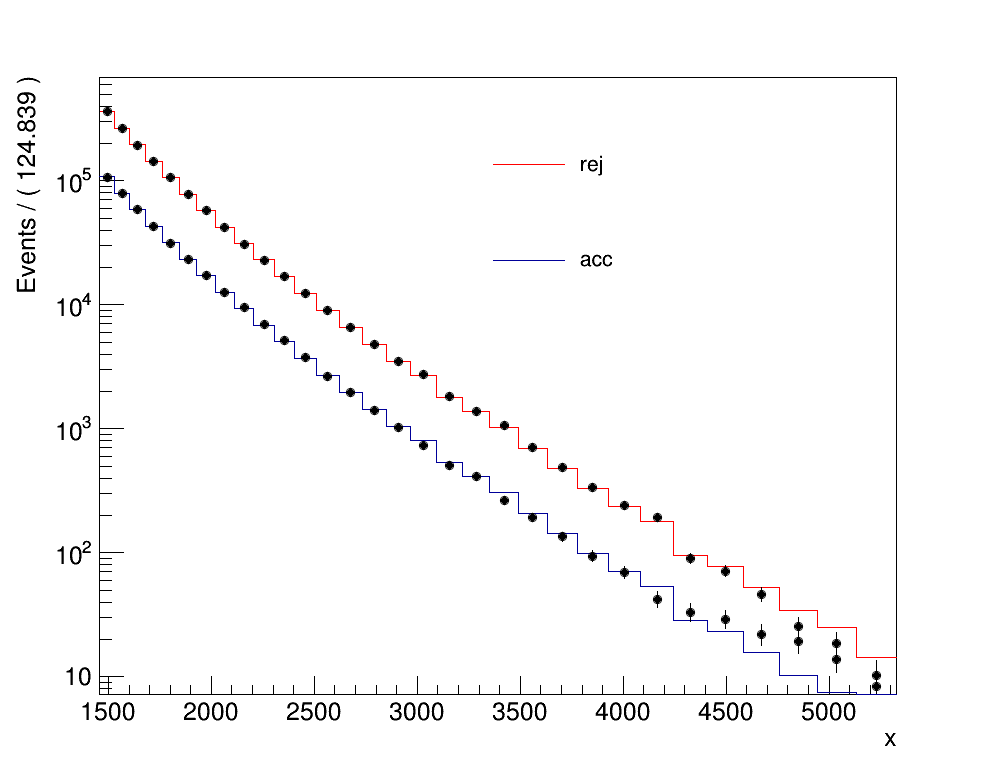

In [5]:
# Debug! Run and inspect the fit from fitDiagnostics

xs = xsecs[0]
key = 0.1

print("For q = {}".format(key) )
quantile = int(key*100)
prefix = "q{}_xs{}_{}".format(quantile,xs,tag)
        
os.system('combine -M FitDiagnostics -d datacard_ws_{PREFIX}_ratio.txt  -n _{PREFIX} --saveShapes --saveWithUncertainties --dataset data_obs --verbose 2'.format(PREFIX=prefix))
fitDiag = rt.TFile.Open('fitDiagnostics_{PREFIX}.root'.format(PREFIX=prefix),'r')


f = rt.TCanvas('f','f',1000,800)
f.cd()

tleg = rt.TLegend(0.48, 0.6, 0.89, 0.85)
tleg.SetTextSize(0.05)
tleg.SetBorderSize(0)
tleg.SetFillStyle(0)
tleg.SetTextSize (0.03)
tleg.SetTextFont( 62 )
tleg.SetTextSize (0.03)
tleg.SetTextFont( 42 )

byhand_gof = 0.0
# for cat in ['q10_rej', 'q10_acc']:
for cat in ['rej', 'acc']:
    print cat
    bkgd = fitDiag.Get('shapes_fit_b/{cat}/background'.format(cat=cat))
    bkgd.Scale(bws) # need to multiply by bin width for some reason?
    data = fitDiag.Get('shapes_fit_b/{cat}/data'.format(cat=cat))
    if cat.find('rej')!=-1:
        bkgd.Draw('hist')
        bkgd.SetLineColor(rt.kRed)
#         bkgd.SetMinimum(10E3)
#         bkgd.SetMaximum(20E3)
#         bkgd.GetXaxis().SetRangeUser(2600,2800)
        tleg.AddEntry(bkgd,'rej','l')
    else:
        bkgd.Draw("histsame")
        tleg.AddEntry(bkgd,'acc','l')
    data.SetMarkerStyle(20)
    data.SetMarkerColor(rt.kBlack)
    for i in range(0,bkgd.GetNbinsX()):
        data.SetPointEXlow(i,0)
        data.SetPointEXhigh(i,0)
        data.SetPoint(i,data.GetX()[i], bws*data.GetY()[i]) # need to multiply by bin width for some reason?
        data.SetPointEYlow(i,bws*data.GetErrorYlow(i)) # need to multiply by bin width for some reason?
        data.SetPointEYhigh(i,bws*data.GetErrorYhigh(i)) # need to multiply by bin width for some reason?
    data.Draw('samepez')


    for i in range(0,bkgd.GetNbinsX()):
        mjjvalue = bkgd.GetBinCenter(i+1)
        fi = bkgd.GetBinContent(i+1)
        di = data.GetY()[i]
        if di == 0:
            print ("No data at mjj", mjjvalue)
            print ("fi", fi)
            print ("di", di)
            gofi = 0.
        else:    
            gofi = 2*(fi - di + di*rt.TMath.Log(di/fi)) # see eq. 14 of http://cousins.web.cern.ch/cousins/ongoodness6march2016.pdf
        # expect each bin to give GOF contribution ~ O(1)
        if gofi>5:
#             print('{cat} bin {i}: fi={fi}, di={di}, gofi={gofi}'.format(cat=cat,i=i,fi=fi,di=di,gofi=gofi))
            print(" Category {}: mjj bin = {} gof = {}".format(cat,mjjvalue,gofi))
        byhand_gof += gofi

tleg.Draw('same')
f.SetLogy()
f.Draw()
f.SaveAs("{}_fitResults_combined.pdf".format(prefix))

print("Done with quantile ",prefix )

print("By hand obs GOF = {}".format(byhand_gof))
obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]
print("Combine obs GOF = {}".format(obs_gof))
# print("Combine exp GOF (mean) = {}".format(np.mean(exp_gof)))

# print("p-value = 



xsec=0:
q = 0.01
sig inj = 0.0 fb, gof = 36.01, p-value (from chi2) = 0.421235, p-value (from toys) = 0.424000

xsec=10:
q = 0.01
sig inj = 10.0 fb, gof = 35.73, p-value (from chi2) = 0.434031, p-value (from toys) = 0.427000

xsec=20:
q = 0.01
sig inj = 20.0 fb, gof = 36.08, p-value (from chi2) = 0.417829, p-value (from toys) = 0.418000

xsec=40:
q = 0.01
sig inj = 40.0 fb, gof = 38.52, p-value (from chi2) = 0.313367, p-value (from toys) = 0.298000

xsec=60:
q = 0.01
sig inj = 60.0 fb, gof = 43.05, p-value (from chi2) = 0.164740, p-value (from toys) = 0.155000

xsec=80:
q = 0.01
sig inj = 80.0 fb, gof = 49.46, p-value (from chi2) = 0.053486, p-value (from toys) = 0.056000

xsec=100:
q = 0.01
sig inj = 100.0 fb, gof = 57.56, p-value (from chi2) = 0.009512, p-value (from toys) = 0.007000

xsec=0:
q = 0.1
sig inj = 0.0 fb, gof = 29.02, p-value (from chi2) = 0.751392, p-value (from toys) = 0.717000

xsec=10:
q = 0.1
sig inj = 10.0 fb, gof = 28.90, p-value (from chi2) = 0.756493, p-value (

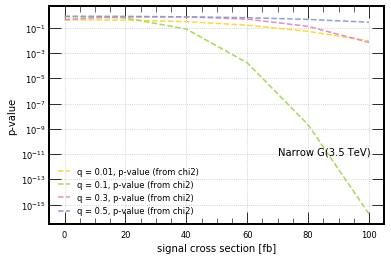

In [13]:
# Make a nice plot for how the p-value chnges with the amount of injected signal
# Requires evaluation of >1 signal strengths

xsecs   = [0,10,20,40,60,80,100]

#Color style
scol = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc'] *3
scol.reverse()
bcol = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f'] *3
bcol.reverse()

all_pvals          = {}
all_pvals_fromtoys = {}
all_gofs           = {}
all_exp_gofs       = {}


for key in sorted(columns.keys()): 
    pvals = []
    pvals_fromtoys = []
    gofs = []
    exp_gofs = []
    for xs in xsecs:
        print("\nxsec={}:".format(xs) )
        print("q = {}".format(key) )
        quantile = int(key*100)
        prefix = "q{}_xs{}_{}".format(quantile,xs,tag)

        # open file
        obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
        obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]


        exp_gof_file = uproot.open('higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root'.format(PREFIX=prefix))
        exp_gof = exp_gof_file['limit'].arrays('limit')['limit']
        
        exp_gofs.append(exp_gof)

        # get p-value from toys
        n_extreme = len(exp_gof[exp_gof > obs_gof])
        n_total = len(exp_gof)
        pval_toys = 1.*n_extreme/n_total
        pvals_fromtoys.append(pval_toys)

        # get p-value assuming chi2 dist (may not be valid)
        pval = rt.TMath.Prob(obs_gof,n_bins)
        pvals.append(pval)
        gofs.append(obs_gof)
        print('sig inj = %.1f fb, gof = %.2f, p-value (from chi2) = %.6f, p-value (from toys) = %.6f'%(xs,obs_gof,pval,pval_toys))
        
        all_pvals          [key] = pvals         
        all_pvals_fromtoys [key] = pvals_fromtoys
        all_gofs           [key] = gofs          
        all_exp_gofs       [key] = exp_gofs      


fig = plt.figure() 
ax = fig.add_subplot(111)
ax.grid()
import cmsstyle 

crossections = np.array(xsecs)

for i,key in enumerate(sorted(columns.keys())): 
    ax.plot(crossections,all_pvals[key],label='q = {}, p-value (from chi2)'.format(key),linestyle='dashed',c=bcol[i])
#     ax.plot(crossections,all_pvals_fromtoys[key],label='q = {}, p-value'.format(key),linestyle='solid',c=bcol[i])
# plt.semilogx()
ax.semilogy()
plt.xlabel('signal cross section [fb]')
plt.ylabel('p-value')
# ax.text(70, 10e-11, r'N toys = 1000')
ax.text(70, 10e-12, r'Narrow G(3.5 TeV)')
ax.legend(loc='lower left')
fig.savefig('pvalue_vs_xs_{}.pdf'.format(tag))